# Exercise 5: Machine Translation with Transformers


In [1]:
skip_training = False   # You can set it to True if you want to run inference on your trained model.

In [3]:
path = "/content/dataset_ex5" # you can change the path if you want to store the dataset somewhere else.

Import all necessary libraries.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore")

# Set random seeds for all libraries
import random
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Task 1: Data Preparation

### Task 1.1: Tokenizaion

In [7]:
# Load your data
en_df = pd.read_csv(os.path.join(path , 'small_vocab_en.csv'), header=None, usecols=[0])
fr_df = pd.read_csv(os.path.join(path, 'small_vocab_fr.csv'), header=None, usecols=[0])

english_sentences = en_df[0].values
french_sentences = fr_df[0].values

print(f'There are {len(english_sentences)} English sentences in data')
print(f'There are {len(french_sentences)} French sentences in data')
print('Here are some examples:')
e = [ 0, 1000, 3000]
for i in e:
    print(10*"-")
    print(english_sentences[i])
    print(french_sentences[i])
print(100*"_")

There are 137860 English sentences in data
There are 137860 French sentences in data
Here are some examples:
----------
new jersey is sometimes quiet during autumn 
new jersey est parfois calme pendant l' automne 
----------
they like strawberries 
ils aiment les fraises 
----------
she plans to visit the united states next may .
elle envisage de se rendre aux états-unis en mai prochain .
____________________________________________________________________________________________________


In [ ]:
# Tokenize function
def tokenize(sentences):
    """
    Tokenizes a list of sentences by:
    1. Converting all text to lowercase.
    2. Removing special characters listed in "filters".
    Hint: you can use "str.maketrans" to creates a translation table to remove unwanted characters defined in "filters".
    3. Splitting each sentence into a list of words.
    """
    filters = '.?!#$%&()*+,-/:;<=>@«»""[\\]^_`{|}~\t\n'

    tokenized_list = []
    for sentence in sentences:
        sentence = sentence.lower()
        sentence = sentence.translate(str.maketrans('', '', filters))
        tokenized_list.append(sentence.split())

    return tokenized_list

# Tokenize English and French sentences
tokenized_en = tokenize(english_sentences)
tokenized_fr = tokenize(french_sentences)
for i in e:
    print(10*"-")
    print(tokenized_en[i])
    print(tokenized_fr[i])

----------
['new', 'jersey', 'is', 'sometimes', 'quiet', 'during', 'autumn']
['new', 'jersey', 'est', 'parfois', 'calme', 'pendant', "l'", 'automne']
----------
['they', 'like', 'strawberries']
['ils', 'aiment', 'les', 'fraises']
----------
['she', 'plans', 'to', 'visit', 'the', 'united', 'states', 'next', 'may']
['elle', 'envisage', 'de', 'se', 'rendre', 'aux', 'étatsunis', 'en', 'mai', 'prochain']


### Task 1.2: Building Vocabulary

In [ ]:
# Create vocabulary with special tokens
def build_vocab(tokenized_sentences):
    special_tokens = ["<PAD>", "<SOS>", "<EOS>"]
    # build vocab by applying "Counter" for sentence in tokenized_sentences and for token in sentence
    # add special tokens
    # word2idx = ? (a dictionary for mapping word to index)
    # idx2word = ? (a dictionary for index to word)
    word2idx = {}
    idx2word = {}

    # add special tokens to the vocab
    for i, token in enumerate(special_tokens):
        word2idx[token] = i
        idx2word[i] = token

    # add the rest of the words to the vocab
    idx = len(special_tokens)
    for sentence in tokenized_sentences:
        for token in sentence:
            # check if token exists already
            if token not in word2idx:
                word2idx[token] = idx
                idx2word[idx] = token
                idx += 1

    return word2idx, idx2word

en_word2idx, en_idx2word = build_vocab(tokenized_en)
fr_word2idx, fr_idx2word = build_vocab(tokenized_fr)

print("Here are some examples from our English dictionary: ")
print(100 * "-")

# Display first 10 words and their indices from en_word2idx
for i, (key, value) in enumerate(en_word2idx.items()):
    print(f'word: {key}, index: {value}')
    if i == 9:  # After 10 iterations, break
        break

print(10 * "_")

# Display first 10 indices and their words from en_idx2word
for i, (key, value) in enumerate(en_idx2word.items()):
    print(f'index: {key}, word: {value}')
    if i == 9:  # After 10 iterations, break
        break

Here are some examples from our English dictionary: 
----------------------------------------------------------------------------------------------------
word: <PAD>, index: 0
word: <SOS>, index: 1
word: <EOS>, index: 2
word: new, index: 3
word: jersey, index: 4
word: is, index: 5
word: sometimes, index: 6
word: quiet, index: 7
word: during, index: 8
word: autumn, index: 9
__________
index: 0, word: <PAD>
index: 1, word: <SOS>
index: 2, word: <EOS>
index: 3, word: new
index: 4, word: jersey
index: 5, word: is
index: 6, word: sometimes
index: 7, word: quiet
index: 8, word: during
index: 9, word: autumn


### Dataset Class

In [12]:
# Dataset class with padding applied in __getitem__
class TranslationDataset(Dataset):
    def __init__(self, src_sentences, tgt_sentences, src_vocab, tgt_vocab, seq_len=30):
        self.src_sentences = src_sentences
        self.tgt_sentences = tgt_sentences
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.seq_len = seq_len

    def __len__(self):
        return len(self.src_sentences)

    def pad_sequence(self, tokens, vocab, is_target=False):
        """
        Pads a sequence of tokens to the fixed length `seq_len`.
        Adds <SOS> at the start, <EOS> at the end, and pads with <PAD>.
        Trims if the sequence is longer than `seq_len`.
        """
        tokens = [vocab["<SOS>"]] + [vocab.get(token, vocab["<PAD>"]) for token in tokens]
        tokens.append(vocab["<EOS>"])
        tokens = tokens[:self.seq_len]
        tokens += [vocab["<PAD>"]] * (self.seq_len - len(tokens))
        return tokens

    def __getitem__(self, idx):

        src_tokens = self.src_sentences[idx]
        tgt_tokens = self.tgt_sentences[idx]

        # Apply padding to both the source and target sentences
        src_padded = self.pad_sequence(src_tokens, self.src_vocab, is_target=False)
        tgt_padded = self.pad_sequence(tgt_tokens, self.tgt_vocab, is_target=True)

        # Convert to tensors and move to device (GPU or CPU)
        src_item = torch.tensor(src_padded).to(device)
        tgt_item = torch.tensor(tgt_padded).to(device)

        return src_item, tgt_item

# Instantiate and test the dataset, let the French be as source language and English as target language.
dataset = TranslationDataset(tokenized_fr, tokenized_en, fr_word2idx, en_word2idx,  seq_len=10)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Test the DataLoader
for src_batch, tgt_batch in dataloader:
    print("Source batch:", src_batch)
    print(src_batch.size())
    print(10*"_")
    print("Target batch:", tgt_batch)
    print(tgt_batch.size())
    print(10*"_")
    break

Source batch: tensor([[  1,  39,  65,   5,   6, 104,  15,  64,   2,   0]], device='cuda:0')
torch.Size([1, 10])
__________
Target batch: tensor([[ 1, 58,  5,  6, 87,  8, 57,  2,  0,  0]], device='cuda:0')
torch.Size([1, 10])
__________


### Task 1.3: Sentence Embedding


In [ ]:
embedding_size = 128
vsize_src = len(fr_word2idx)
vsize_tgt = len(en_word2idx)

# data: let the French be as source language and English as target language.
dataset = TranslationDataset(tokenized_fr, tokenized_en, fr_word2idx, en_word2idx,  seq_len=10)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Use 'next' to get a batch from the DataLoader iterator
src_batch, tgt_batch = next(iter(dataloader))


embedding_fr = nn.Embedding(vsize_src, embedding_size) #(define an embedding layer for French words in your French Vocabulary)
embedding_fr.to(device)
output_embedding_fr = embedding_fr(src_batch) #(pass src_batch through embedding_fr)


embedding_en = nn.Embedding(vsize_tgt, embedding_size) # (define an embedding layer for English words in your English Vocabulary)
embedding_en.to(device)
output_embedding_en = embedding_en(tgt_batch)

print(10*"_")
print(src_batch.size())
print(output_embedding_fr.size())
print(10*"_")
print(tgt_batch.size())
print(output_embedding_en.size())

__________
torch.Size([1, 10])
torch.Size([1, 10, 128])
__________
torch.Size([1, 10])
torch.Size([1, 10, 128])


### Task 1.4: Positional encoding

In [15]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, max_len=512):
        super(PositionalEncoding, self).__init__()
        self.embed_size = embed_size

        # Initialize a tensor to store positional encodings for each position up to max_len
        pos_encoding = torch.zeros(max_len, embed_size)
        # Create a tensor for positions, where each position corresponds to a word's position in the sequence
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # 1. Create a tensor `div_term` to scale the positional encoding values.

        # Hint:
        # This is based on the formula for positional encoding where each dimension has a different frequency.
        # We generate a range of values from 0 to embed_size, stepping by 2 (for even indices), and multiply it by a scaling factor.
        # The scaling factor (-math.log(10000.0) / embed_size) ensures the frequencies decay logarithmically.

        # 2. Apply the sine function to the even indices of the positional encoding matrix.
        # 3. Apply the cosine function to the odd indices of the positional encoding matrix.

        # Hint:
        # The `position` tensor holds the position values for each token, and `div_term` scales those values.

        # YOUR CODE HERE
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-math.log(10000.0) / embed_size))
        pos_encoding[:, 0::2] = torch.sin(position * div_term)
        pos_encoding[:, 1::2] = torch.cos(position * div_term)

        # Register as buffer so it is not considered as a parameter during training
        self.register_buffer('pos_encoding', pos_encoding.unsqueeze(0))

    def forward(self, x):
        # Add positional encoding to embeddings
        x = x * math.sqrt(self.embed_size)
        x = x + self.pos_encoding[:, :x.size(1), :].to(x.device)
        return x

In [16]:
#%% Applying positional encoding
positional_encoding = PositionalEncoding(embedding_size, 512)
output_pe_fr = positional_encoding (output_embedding_fr)
output_pe_en = positional_encoding (output_embedding_en)
print(10*"_")
print(output_pe_fr.size())
print(output_pe_en.size())

__________
torch.Size([1, 10, 128])
torch.Size([1, 10, 128])


## Task 2: Model Architecture

In [ ]:
class MyTransformer(nn.Module):
    def __init__(self, vocab_size_src, vocab_size_tgt, embed_size, num_heads, hidden_dim, num_encoder_layers, num_decoder_layers, max_len=512):
        super(MyTransformer, self).__init__()
        # Initialize layers similar to MySimpleTransformer
        # Two Embedding layers for source and target text
        # Positional encoding
        # Transformer block
        # Final linear layer to project transformer output to vocab size
        self.embedding_src = nn.Embedding(vocab_size_src, embed_size).to(device)
        self.embedding_tgt = nn.Embedding(vocab_size_tgt, embed_size).to(device)
        self.positional_encoding = PositionalEncoding(embed_size, max_len)
        self.transformer = nn.Transformer(d_model=embed_size,
                                          nhead=num_heads,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=hidden_dim)
        self.linear = nn.Linear(embed_size, vocab_size_tgt)

    def encode(self, src, src_padding_mask):
        # Transpose inputs to (seq_len, batch_size, embedding_dim)
        src = src.transpose(0, 1)

        # 1. Get embeddings for source
        # 2. apply positional encoding to embedded source
        # 3. Forward pass to Transformer encoder block with src_key_padding_mask
        src_embedding = self.embedding_src(src)
        src_pe = self.positional_encoding(src_embedding)
        encoded = self.transformer.encoder(src_pe,
                               src_key_padding_mask=src_padding_mask)

        return encoded

    def decode(self, tgt, memory, tgt_mask, tgt_padding_mask):
        # Transpose inputs to (seq_len, batch_size, embedding_dim)
        tgt = tgt.transpose(0, 1)
        if tgt_mask != None:
            tgt_mask = tgt_mask.transpose(0,1)

        # 1. Get embeddings for target
        # 2. apply positional encoding to embedded target
        # 3. Forward pass target and memory (output of encode) to Transformer decoder block with tgt_mask
        tgt_embedding = self.embedding_tgt(tgt)
        tgt_pe = self.positional_encoding(tgt_embedding)
        decoded = self.transformer.decoder(tgt_pe,
                               memory,
                               tgt_mask=tgt_mask,
                               tgt_key_padding_mask=tgt_padding_mask)

        return decoded

    def forward(self, src, tgt, src_padding_mask=None, tgt_padding_mask=None, tgt_mask=None):
        # 1. pass source through encode block (name it as memory)
        # 2. pass target and memory through decode block
        # 3. Project to vocabulary size
        memory = self.encode(src,
                             src_padding_mask)
        output_decoder = self.decode(tgt,
                                     memory,
                                     tgt_mask,
                                     tgt_padding_mask)
        output = self.linear(output_decoder)

        output = output.transpose(0, 1)
        return  output_decoder, output

    def get_tgt_mask(self, tgt):
        tgt_seq_len = tgt.size(1)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_seq_len).to(tgt.device)
        return tgt_mask

    def create_pad_mask(self, matrix):
        # If matrix = [1,2,3,0,0,0] where pad_token=0, the result mask is
        # [False, False, False, True, True, True]
        pad_token = 0
        return (matrix == pad_token)

## Task 3: Training and Evaluation

In [23]:
# Data

bs = 256
dataset = TranslationDataset(tokenized_fr, tokenized_en, fr_word2idx, en_word2idx,  seq_len=7)
number_of_sentences = len(tokenized_fr)
train_size = int((0.8)*number_of_sentences)
test_size = int(number_of_sentences - train_size)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, drop_last=True)
val_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False, drop_last=True)

In [24]:
# Model

embedding_size = 240 # embed_dim must be divisible by num_heads
vsize_src = len(fr_word2idx) # 336
vsize_tgt = len(en_word2idx) # 201
hdim = 512
model = MyTransformer(vsize_src, vsize_tgt, embedding_size, 6, hdim, 4, 4, max_len=256)
model = model.to(device)

Epoch 1/10, Train Loss: 1.0225
Epoch 1/10, Validation Loss: 0.1464
Epoch 2/10, Train Loss: 0.133
Epoch 2/10, Validation Loss: 0.0899
Epoch 3/10, Train Loss: 0.0927
Epoch 3/10, Validation Loss: 0.0783
Epoch 4/10, Train Loss: 0.0817
Epoch 4/10, Validation Loss: 0.0743
Epoch 5/10, Train Loss: 0.0769
Epoch 5/10, Validation Loss: 0.0729
Epoch 6/10, Train Loss: 0.0744
Epoch 6/10, Validation Loss: 0.0731
Epoch 7/10, Train Loss: 0.0731
Epoch 7/10, Validation Loss: 0.0712
Epoch 8/10, Train Loss: 0.0717
Epoch 8/10, Validation Loss: 0.0699
Epoch 9/10, Train Loss: 0.0711
Epoch 9/10, Validation Loss: 0.0696
Epoch 10/10, Train Loss: 0.0702
Epoch 10/10, Validation Loss: 0.0703
Training completed.


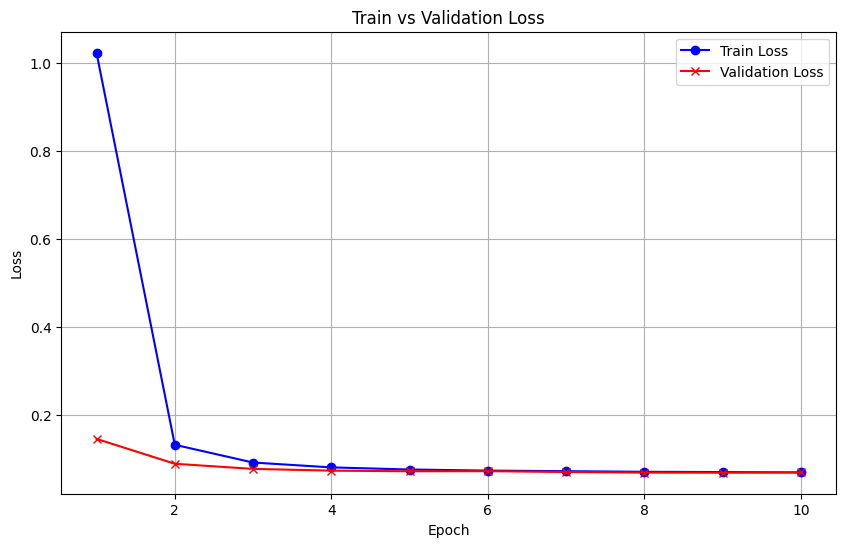

In [ ]:
# Training
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
num_epochs = 10

if not skip_training:
    epoch_train_losses = []
    epoch_validation_losses = []
    for epoch in range(num_epochs):
        model = model.to(device)
        model.train()  # Set model to training mode
        total_loss = 0
        num_samples = 0
        for src_batch, tgt_batch in train_loader:
            optimizer.zero_grad()
            # set input source as src_batch
            # set input target as start of target sentence untill -1 (i.e. discard the last token) (past) [name it as tgt_input]
            # set expexted target as target sentence from 1 to the end (i.e. discard the first token) (future) [name it as tgt_expected]
            # use input source and input target (tgt_input) as input to the model
            # expexted target will be used in loss to compare it with the model output.
            # Remember to use padding and target causal masks on the model call:
            # get padding mask of source,
            # get padding mask of input target, convert it to float (.float()),
            # get tgt_mask of input target,
            # pass inout source, input target, source padding mask, and tgt_mask to the model to get the predictions (output).
            src_batch = src_batch.to(device)
            tgt_batch = tgt_batch.to(device)

            tgt_input = tgt_batch[:, :-1]
            tgt_expected = tgt_batch[:, 1:]

            src_padding_mask = model.create_pad_mask(src_batch)
            tgt_padding_mask = model.create_pad_mask(tgt_input).float()
            
            tgt_mask = model.get_tgt_mask(tgt_input)
            output_decoder, output = model(src_batch, tgt_input, src_padding_mask=src_padding_mask, tgt_padding_mask=tgt_padding_mask, tgt_mask = tgt_mask)

            output = output.to(device)
            output = output.contiguous().view(-1, vsize_tgt)
            tgt_expected = tgt_expected.contiguous().view(-1)

            loss = criterion(output, tgt_expected)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_samples += src_batch.shape[0]

        epoch_train_loss = total_loss / len(train_loader)
        epoch_train_loss = round(epoch_train_loss, 4)
        epoch_train_losses.append(epoch_train_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss}")

        ################################################################

        model.eval()
        validation_loss = 0
        num_samples = 0
        with torch.no_grad():
            for src_batch, tgt_batch in val_loader:
                # set input source as src_batch
                # set input target as start of target sentence untill -1 (i.e. discard the last token) (past) [name it as tgt_input]
                # set expexted target as target sentence from 1 to the end (i.e. discard the first token) (future) [name it as tgt_expected]
                # use input source and input target (tgt_input) as input to the model
                # expexted target will be used in loss to compare it with the model output.
                # Remember to use padding and target causal masks on the model call:
                # get padding mask of source,
                # get padding mask of input target, convert it to float (.float()),
                # get tgt_mask of input target,
                # pass inout source, input target, source padding mask, and tgt_mask to the model to get the predictions (output).
                src_batch = src_batch.to(device)
                tgt_batch = tgt_batch.to(device)

                tgt_input = tgt_batch[:, :-1]
                tgt_expected = tgt_batch[:, 1:]

                src_padding_mask = model.create_pad_mask(src_batch)
                tgt_padding_mask = model.create_pad_mask(tgt_input).float()

                tgt_mask = model.get_tgt_mask(tgt_input)
                output_decoder, output = model(src_batch, tgt_input, src_padding_mask=src_padding_mask, tgt_padding_mask=tgt_padding_mask, tgt_mask = tgt_mask)

                output = output.to(device)
                output = output.contiguous().view(-1, vsize_tgt)

                tgt_expected = tgt_expected.contiguous().view(-1)
                loss = criterion(output, tgt_expected)
                validation_loss += loss.item()
                num_samples += src_batch.shape[0]

            epoch_validation_loss = validation_loss / len(val_loader)
            epoch_validation_loss = round(epoch_validation_loss, 4)
            epoch_validation_losses.append(epoch_validation_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {epoch_validation_loss}")
        torch.save(model.state_dict(), 'model.pth')

    print("Training completed.")
    torch.save(model.state_dict(), 'model.pth')

    plt.figure(figsize=(10, 6))
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, epoch_train_losses, label='Train Loss', color='blue', marker='o')
    plt.plot(epochs, epoch_validation_losses, label='Validation Loss', color='red', marker='x')
    plt.title('Train vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

## Task 4: Autoregressive Translation

In [ ]:
seq_len=10
start_token=1
end_token=2
model.eval()

# Convert src_sentence to tokenized integers in the vocabulary dictionary
example_source_sentences = ["new jersey est parfois calme pendant l' automne.", "california est généralement calme en mars."]
example_tokenized = tokenize(example_source_sentences)
src_sentences = []
for ex in example_tokenized:
    ex_inds = []
    for t in ex:
        t_ind = fr_word2idx [t]
        ex_inds.append(t_ind)
    src_sentences.append(ex_inds)

translated_sequences = []
for counter, src_sentence in enumerate(src_sentences):
    # Convert source tokens to Tensor
    src_tensor = torch.tensor(src_sentence, dtype=torch.long).unsqueeze(0).to(device)  # Shape: (1, src_seq_length)

    # 1. create src_padding_mask
    # 2. get "memory" by passing source with create src_padding_mask through encode block (model.encode)
    src_padding_mask = model.create_pad_mask(src_tensor)
    memory = model.encode(src_tensor, src_padding_mask)

    # initialize the predicted tgt_tokens (translation) with start token
    tgt_tokens = torch.ones(1, 1).fill_(start_token).type(torch.long).to(device) #(1,1)

    for i in range(seq_len-1):
        # 1. Mask out the unpredicted tokens in the target (i.e., get tgt_mask)
        # 2. get output by passing target (the generated part up to current `i`) and memory to decode block (model.decode)
        # 3. remember to pass also tgt_mask
        # 4. get a probability vector by passing output through linear layer (projection to vocabulary size)
        # 5. use "torch.max" to get the index of the predicted word
        # 6. Convert it to a tensor on device (name it as "next_tgt_item")
        # 7. add "next_tgt_item" to tgt_tokens (use torch.cat)
        # 8. Stop (break) if "end_token" is generated
        tgt_mask = model.get_tgt_mask(tgt_tokens)
        output_decoder = model.decode(tgt_tokens, memory, tgt_mask, None)
        output = model.linear(output_decoder)
        output = output.transpose(0, 1)
        prob = torch.max(output, dim=2)[1]
        next_tgt_item = prob[:, -1].unsqueeze(1)
        tgt_tokens = torch.cat((tgt_tokens, next_tgt_item), dim=1)
        if next_tgt_item.item() == end_token:
            break

    translated_tokens = tgt_tokens.squeeze().tolist()
    translated_sentence = ' '.join ([en_idx2word[i] for i in translated_tokens[1:]])
    translated_sequences.append(translated_tokens)
    print("original_sentence:", example_source_sentences[counter])
    print("translated_sentence:", translated_sentence)
    print(10*'-')

np.save('translation.npy', np.array(translated_sequences, dtype=object))

original_sentence: new jersey est parfois calme pendant l' automne.
translated_sentence: quiet during autumn <EOS>
----------
original_sentence: california est généralement calme en mars.
translated_sentence: quiet during march <EOS>
----------
